In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from scipy.signal import medfilt
from scipy.stats import sem, ranksums
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set(font_scale=2, style='ticks')

In [62]:
vol_file = '../Analysis/depreciated/analysis_sections_gain.csv'
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
dat_xls_file = dat_xls_file.reset_index()
t_pre = 100 # time window pre-swim
t_post = 350 # time window post-swim
t_label = np.arange(-t_pre, t_post)/300
t_sig = 240

In [76]:
k_ = gaussKernel(sigma=1)
k_sub = gaussKernel(sigma=11)
p_mat = []
fish_id = []

ave_low_list = []
ave_high_list = []
sub_low_list = []
sub_high_list = []


# ave_low_nolist = []
# ave_high_nolist = []
# sub_low_nolist = []
# sub_high_nolist = []
ave_no_list=[]
sub_no_list=[]

for ind, row in dat_xls_file.iterrows():    
    folder = row['folder']
    fish = row['fish']
    task_type = row['task']
    
    if not os.path.exists(f'../Analysis/swim_voltr_no_swim/{folder}_{fish}_swim_voltr_dat.npz'):
        continue
               
    _ = np.load(f'../Analysis/swim_voltr_no_swim/{folder}_{fish}_swim_voltr_dat.npz')
    trial_valid = _['trial_valid']
    task_period = _['task_period']
    sub_swim = _['sub_swim']
    spk_swim = _['spk_swim']
    sub_noswim = _['sub_noswim']
    spk_noswim = _['spk_noswim']
    no_swim_list=_['no_swim_list']
    if (no_swim_list[:,2]<=2).sum()==0:
        continue
    
    for n_cell in range(sub_swim.shape[0]):
        sub_list = sub_swim[n_cell]
        sub_list = sub_list - sub_list[:, (t_pre-60):t_pre].mean(axis=-1, keepdims=True)
        spk_list = spk_swim[n_cell]
        sub_nolist = sub_noswim[n_cell]
        sub_nolist = sub_nolist - sub_nolist[:, (t_pre-60):t_pre].mean(axis=-1, keepdims=True)
        spk_nolist = spk_noswim[n_cell]
        non_trial = np.isnan(spk_list).sum(axis=-1)==0
        trial_valid = trial_valid & non_trial
        gain_stat = np.zeros(t_pre+t_post)
        for ntime in range(-t_pre, t_post):
            val, pval= ranksums(spk_list[(task_period==1) & trial_valid, t_pre+ntime], 
                                spk_list[(task_period==2) & trial_valid, t_pre+ntime])
            gain_stat[t_pre+ntime] = np.sign(-val) * pval
        p_mat.append(gain_stat)
        ave_low_list.append(spk_list[(task_period==1) & trial_valid].mean(axis=0)*300)
        ave_high_list.append(spk_list[(task_period==2) & trial_valid].mean(axis=0)*300)
        sub_low_list.append(sub_list[(task_period==1) & trial_valid].mean(axis=0)*100)
        sub_high_list.append(sub_list[(task_period==2) & trial_valid].mean(axis=0)*100)
        
#         ave_low_nolist.append(spk_nolist[task_period==1].mean(axis=0)*300)
#         ave_high_nolist.append(spk_nolist[task_period==2].mean(axis=0)*300)
#         sub_low_nolist.append(sub_nolist[task_period==1].mean(axis=0)*100)
#         sub_high_nolist.append(sub_nolist[task_period==2].mean(axis=0)*100)
        ave_no_list.append(spk_nolist[no_swim_list[:,2]<=2].mean(axis=0)*300)
        sub_no_list.append(sub_nolist[no_swim_list[:,2]<=2].mean(axis=0)*100)
        fish_id.append(folder+fish[:5])

In [77]:
# nan_line_wid = 3
# nan_line = np.empty((len(ave_low_list), nan_line_wid))
# nan_line[:] = np.nan
# ave_list = np.concatenate([np.array(ave_low_list), nan_line, np.array(ave_high_list)], axis=-1)
# ave_list_min = np.nanmin(ave_list, axis=-1, keepdims=True)
# ave_list_max = np.nanmax(ave_list, axis=-1, keepdims=True)
# valid = (ave_list_max - ave_list_min) >0
# ave_list = (ave_list - ave_list_min)/(ave_list_max - ave_list_min)

In [78]:
# ave_list_ = ave_list[valid[:,0], :]
# max_ind = np.nanargmax(ave_list_, axis=-1)
# sort_max_ind = np.argsort(max_ind)
# plt.figure(figsize=(8, 3))
# plt.imshow(ave_list_[sort_max_ind, :], aspect='auto', origin='lower')
# plt.vlines([t_pre, t_pre*2+t_post+nan_line_wid], [0], [len(sort_max_ind)], linestyles='--', colors='w')
# plt.ylim([0, len(sort_max_ind)])
# plt.ylabel('Neuronal index')
# plt.xlabel('Time from swim bout onset (sec)')
# plt.xticks([t_pre, t_pre+300, t_pre*2+t_post+nan_line_wid, t_pre*2+t_post+300+nan_line_wid], ['0', '1', '0', '1'])
# plt.yticks([0, len(sort_max_ind)-1], [1, len(sort_max_ind)])
# plt.colorbar()
# sns.despine()
# plt.savefig('../Plots/gain/pop_act_max.pdf')

In [79]:
sig_mat = np.abs(p_mat)[:, t_pre-30:(t_pre+300)]<0.05
sel_ind = sig_mat.sum(axis=-1)>30

In [80]:
sel_ind.sum()

43

<Figure size 288x216 with 0 Axes>

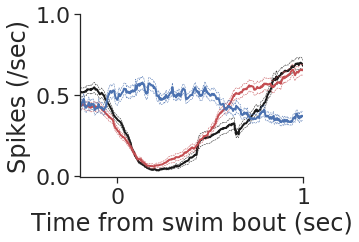

In [85]:
plt.figure(figsize=(4, 3))

ave_act = np.array(ave_low_list)[sel_ind].mean(axis=0)
sem_act = np.array(ave_low_list)[sel_ind].std(axis=0)/np.sqrt(len(ave_low_list))

plt.figure(figsize=(4, 3))
plt.plot(t_label, ave_act, '-k', lw=2)
plt.plot(t_label, ave_act+sem_act, '--k', lw=0.5)
plt.plot(t_label, ave_act-sem_act, '--k', lw=0.5)

ave_act = np.array(ave_high_list)[sel_ind].mean(axis=0)
sem_act = np.array(ave_high_list)[sel_ind].std(axis=0)/np.sqrt(len(ave_high_list))
plt.plot(t_label, ave_act, '-r', lw=2)
plt.plot(t_label, ave_act+sem_act, '--r', lw=0.5)
plt.plot(t_label, ave_act-sem_act, '--r', lw=0.5)

t_label_=(np.arange(1000)-700)/300
ave_act = np.array(ave_no_list)[sel_ind].mean(axis=0)
sem_act = np.array(ave_no_list)[sel_ind].std(axis=0)/np.sqrt(len(ave_high_list))
plt.plot(t_label_, ave_act, '-b', lw=2)
plt.plot(t_label_, ave_act+sem_act, '--b', lw=0.5)
plt.plot(t_label_, ave_act-sem_act, '--b', lw=0.5)

# plt.vlines([0], [0], [1.1], linestyles='--', colors='k')
plt.xlim([-0.2, 1.0])
# plt.ylim([0, 1.1])
plt.yticks(np.arange(0, 1.01, 0.5))
plt.xticks([0, 1])
plt.xlabel('Time from swim bout (sec)')
plt.ylabel('Spikes (/sec)')
sns.despine()
plt.savefig('../Plots/gain/pop_sel_act_ave.svg')